In [9]:
%load_ext autoreload
%autoreload 2

import glob, os, re, pickle
import sys
import torch

import matplotlib.pyplot as plt
import numpy as np

from inxss import PsiMask
from inxss.psimask import downsample_4d_with_map_coordinates

from tqdm import tqdm


from scipy.interpolate import RegularGridInterpolator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
'/pscratch/sd/z/zhantao/inxs_steering/La2NiO4_bool'

In [2]:
map_path = '/pscratch/sd/z/zhantao/inxs_steering/La2NiO4_bool'

In [3]:
map_path = '/pscratch/sd/z/zhantao/inxs_steering/La2NiO4_bool'
psi_mask = PsiMask(map_path, scale_factor=0.5, device='cpu', preload=False)

h_grid
k_grid
l_grid
e_grid


In [4]:
mask = psi_mask.get_mask(65.4).cpu()

In [5]:
masks = []
for _angle in tqdm(np.arange(361)):
    masks.append(psi_mask.get_mask(_angle))

100%|██████████| 361/361 [01:37<00:00,  3.69it/s]


In [6]:
masks = torch.stack(masks)

In [12]:
psi_mask_func = RegularGridInterpolator([np.arange(361), psi_mask.h_grid, psi_mask.k_grid, psi_mask.l_grid, psi_mask.w_grid], masks.numpy())

In [14]:
psi_mask_func([0, 0, 0, 0, 10])

array([0.])

In [20]:
grid = torch.moveaxis(torch.stack(torch.meshgrid(psi_mask.h_grid, psi_mask.k_grid, psi_mask.l_grid, psi_mask.w_grid, indexing='ij'), dim=0), 0, -1)

grid = torch.cat([torch.zeros_like(grid[..., 0:1]), grid], dim=-1)

In [25]:
mask_scipy = psi_mask_func(grid.numpy())

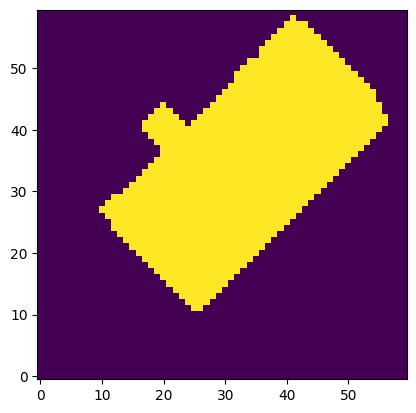

In [27]:

plt.figure()
plt.imshow(mask_scipy.sum(axis=-1).sum(axis=-1).T > 0, origin='lower')

In [5]:
%timeit psi_mask.get_mask(2.0)

192 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


tensor(0.0024)
0.0022286522633744857


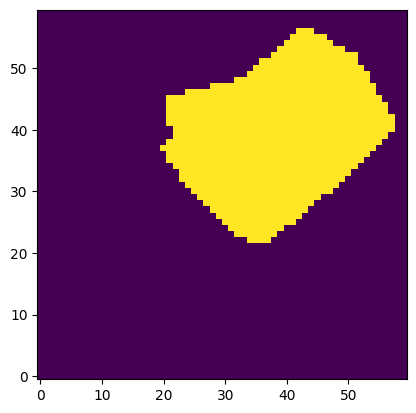

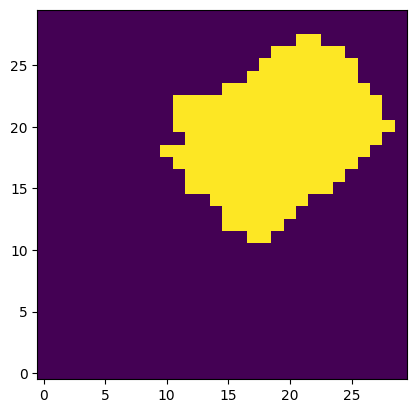

In [6]:
print(mask.sum() / mask.numel())
plt.figure()
plt.imshow(mask.sum(axis=-1).sum(axis=-1).T > 0, origin='lower')

downsampled_mask = downsample_4d_with_map_coordinates(mask.float().cpu().numpy(), 0.5, order=0)
print(downsampled_mask.sum() / np.prod(downsampled_mask.shape))
plt.figure()
plt.imshow(downsampled_mask.sum(axis=-1).sum(axis=-1).T > 0, origin='lower')